Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [43]:
import pipeline_evictions as pipeline
import ml_loop_evictions as loop

import importlib
import datetime
import pandas as pd
import numpy as np


# Read data

In [44]:
importlib.reload(pipeline)

datafile = "data/tracts.csv"

#Read data, parsing year column to date type
data = pd.read_csv(datafile, parse_dates=['year'])

# Explore data

In [45]:
#--->PENDING


# Create outcome label

In [46]:
def get_eviction_rate(df, year,geoid):
  

  data_in_4_years_for_geoid = df.loc[(df['year'] == year) & (df['GEOID'] == geoid)]
  
#   print("year:"+str(year))
#   print("in year:"+str(date_in_4_years))
#   print("geoid"+str(geoid))
#   print(data_in_4_years_for_geoid['eviction-rate'])
  
  return data_in_4_years_for_geoid['eviction-rate'].iloc[0]

In [47]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#--->PENDING

#Obtain eviction-rate cutoff for the top 10%, for each year
cutoff_10_percent={}
for year in range(2000,2017):
    year = pd.Timestamp(year,1,1)
    cutoff_10_percent[year]=data.loc[data['year'] == year]['eviction-rate'].quantile(.9)
    
top_10_eviction_rate_column = np.zeros(len(data))

for index, row in data.iterrows():
  
  #Because the outcome will come from eviction-rate in 4 years and we have data till 2016,
  #features data bust be from 2012 or before
  
  if(row['year']<=pd.Timestamp(2012,1,1)):    
    date_in_4_years = row['year'] + relativedelta(years=4)
    eviction_rate_in_4_years = get_eviction_rate(data, date_in_4_years,row['GEOID'])

#     print(row['year'])
#     print(date_in_4_years)
#     print(eviction_rate_in_4_years)
    
    top_10_eviction_rate_in_4_years = 1 if eviction_rate_in_4_years>= cutoff_10_percent[date_in_4_years] else 0
    top_10_eviction_rate_column[index]=top_10_eviction_rate_in_4_years

data['top_10_percent_in_4_years'] = top_10_eviction_rate_column

label ='top_10_percent_in_4_years'

# Create temporal train and test sets

In [48]:
importlib.reload(pipeline)

#Create sets of train and test data, based on different split thresholds
#The split thresholds corresponds to the starting date of the testing data

#Splits according to https://docs.google.com/spreadsheets/d/1ipqsgThz7hdXXyyNpTuqa4J1inc088lop7lhFsAQ_r0/edit#gid=0
split_thresholds = [pd.Timestamp(i,1,1) for i in range (2005, 2013)]

#Indicating which is the column to be used for splitting training and test daata
date_column='year'

#Amount of data used for test set
test_window = relativedelta(years=5)

#Gap needed between training and test set
gap_training_test = relativedelta(years=4)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  label,
  split_thresholds,
  test_window,
  gap_training_test)

In [49]:
#Checking train_test sets where generated correctly
train_test_sets[1]['x_test'].head(10)

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,...,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed,top_10_percent_in_4_years
6,51001090100,2006-01-01,901.0,"Accomack County, Virginia",4296.03,7.33,380.0,19.38,702.00,38578.00,...,0.00,0.00,9.0,5.0,1.32,2.37,0,0,0,0.0
23,51001090200,2006-01-01,902.0,"Accomack County, Virginia",5835.96,8.94,734.0,25.61,723.97,42071.98,...,1.61,0.00,23.0,15.0,2.04,3.13,0,0,0,0.0
40,51001090300,2006-01-01,903.0,"Accomack County, Virginia",3189.61,18.91,227.0,26.95,681.12,38282.67,...,1.58,0.00,10.0,7.0,3.08,4.40,0,0,0,0.0
57,51001090400,2006-01-01,904.0,"Accomack County, Virginia",7539.45,17.33,770.0,33.20,742.82,30691.06,...,1.15,0.00,18.0,10.0,1.30,2.34,0,0,0,0.0
74,51001090500,2006-01-01,905.0,"Accomack County, Virginia",3026.45,12.56,341.0,23.78,688.77,40511.90,...,0.71,1.55,12.0,7.0,2.05,3.52,0,0,0,0.0
91,51001090600,2006-01-01,906.0,"Accomack County, Virginia",5733.93,10.40,505.0,21.92,588.35,44285.18,...,0.33,0.07,8.0,8.0,1.58,1.58,0,0,0,0.0
108,51001090700,2006-01-01,907.0,"Accomack County, Virginia",5114.34,5.66,454.0,23.96,508.53,43218.91,...,0.67,0.00,24.0,13.0,2.86,5.29,0,0,0,0.0
125,51001090800,2006-01-01,908.0,"Accomack County, Virginia",3752.96,4.73,415.0,14.44,775.00,42214.00,...,1.04,0.00,13.0,6.0,1.45,3.13,0,0,0,0.0
142,51001980100,2006-01-01,9801.0,"Accomack County, Virginia",6.97,7.33,0.0,19.38,702.00,38578.00,...,0.00,0.00,0.0,0.0,0.00,0.00,0,0,0,0.0
159,51001980200,2006-01-01,9802.0,"Accomack County, Virginia",26.29,8.93,3.0,25.61,724.00,42075.00,...,1.61,0.00,0.0,0.0,0.00,0.00,0,0,0,0.0


# Process data

In [50]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set

#--->PENDING
#In the meantime, imputing all float columns with mean

float_columns = [column for column in data.columns if data[column].dtype=='float']

#Do not consider GEOID column
float_columns=float_columns[1:]

for train_test_set in train_test_sets:
  train_data = train_test_set['x_train']
  test_data = train_test_set['x_test']

  #fill na values with mean
  pipeline.fill_na_columns_with_mean(train_data, float_columns)
  pipeline.fill_na_columns_with_mean(test_data, float_columns)


# Create features

In [51]:
importlib.reload(pipeline)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:
  
  #--->PENDING. create_features function
  train_features, test_features = pipeline.create_features(train_test_set)

  #Replace raw data in train_test_set with features generated
  train_test_set['x_train'] = train_features
  train_test_set['x_test'] = test_features

In [52]:
# for train_test_set in train_test_sets:
#   print(train_test_set['y_train'].head())

# Build Clasifiers and parameters generation

In [60]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['DT','LR','RF','ET','KNN','NB','BA','AB','GB']#'SVM'

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()

# Loop over models and different training/test sets

In [61]:
importlib.reload(pipeline)
importlib.reload(loop)

import warnings

warnings.filterwarnings('ignore')

results = loop.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

2019-06-02 20:19:06.874553: Running DT with params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:07.431914: Running DT with params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:07.797335: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:08.338545: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:08.893015: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:09.157382: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:09.505571: Running DT with params: {'criterion': 'gini', 'max_depth':

2019-06-02 20:19:41.930509: Running ET with params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:42.418938: Running ET with params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1000} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:44.437479: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:44.907141: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:46.788589: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:47.056355: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} on train/test set 2005-01-01 00:00:00
2019-06-02 20:19:47.399582: Running KNN with params: {'algorithm': 'auto', 'n_nei

2019-06-02 20:20:06.641747: Running DT with params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:06.972425: Running DT with params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:07.335268: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:07.660325: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:08.003590: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:08.366008: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:08.686307: Running LR with params: {'C': 0.00

2019-06-02 20:20:44.311839: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:44.617532: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:44.924796: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:45.257067: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:45.569497: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:45.887220: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'} on train/test set 2006-01-01 00:00:00
2019-06-02 20:20:46.203840: Running KNN with pa

2019-06-02 20:21:09.105806: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:09.582836: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:10.346743: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:10.848761: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:11.552744: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:12.028785: Running RF with params

2019-06-02 20:21:46.143883: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 10} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:46.500069: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 100} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:47.403288: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 10} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:47.751881: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 100} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:48.705308: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 0.1} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:49.015277: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 1.0} on train/test set 2007-01-01 00:00:00
2019-06-02 20:21:49.368129: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100, 'subsample': 0.1} on train/test set 2007-01-01 00:00:00
20

2019-06-02 20:22:12.129907: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2008-01-01 00:00:00
2019-06-02 20:22:13.297326: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2008-01-01 00:00:00
2019-06-02 20:22:13.797873: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2008-01-01 00:00:00
2019-06-02 20:22:14.953074: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100} on train/test set 2008-01-01 00:00:00
2019-06-02 20:22:15.459224: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 1000} on train/test set 2008-01-01 00:00:00
2019-06-02 20:22:17.644137: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100} on train/test se

2019-06-02 20:22:54.297308: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:54.811431: Running DT with params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:55.172746: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:55.659579: Running DT with params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:57.065735: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:57.971738: Running DT with params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 5} on train/test set 2009-01-01 00:00:00
2019-06-02 20:22:59.251515: Running DT with params: {'criterion': 'gini', 'max_depth

2019-06-02 20:24:01.713150: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:02.481166: Running ET with params: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:06.202139: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:06.557933: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:06.873626: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:07.197694: Running KNN with params: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2009-01-01 00:00:00
2019-06-02 20:24:07.568290: Running KNN with params: {'algorithm': 'auto', 'n_n

2019-06-02 20:24:37.094692: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 2} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:37.500595: Running DT with params: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 5} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:37.884154: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 2} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:38.287717: Running DT with params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:38.685291: Running LR with params: {'C': 0.001, 'penalty': 'l1'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:39.081721: Running LR with params: {'C': 0.001, 'penalty': 'l2'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24:39.518774: Running LR with params: {'C': 0.1, 'penalty': 'l1'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:24

2019-06-02 20:25:22.127503: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:22.474102: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:22.796958: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:23.112473: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:23.459818: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'uniform'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:23.828791: Running KNN with params: {'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'distance'} on train/test set 2010-01-01 00:00:00
2019-06-02 20:25:24.231160: Running KNN with 

2019-06-02 20:26:06.860514: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:26:07.858680: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:26:08.379059: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:26:09.414610: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:26:10.033344: Running RF with params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:26:13.388977: Running RF with param

2019-06-02 20:27:48.359635: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 10} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:48.971389: Running AB with params: {'algorithm': 'SAMME.R', 'n_estimators': 100} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:51.411053: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 0.1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:51.958774: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 10, 'subsample': 1.0} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:52.618586: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100, 'subsample': 0.1} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:53.919168: Running GB with params: {'learning_rate': 0.001, 'n_estimators': 100, 'subsample': 1.0} on train/test set 2011-01-01 00:00:00
2019-06-02 20:27:55.860732: Running GB with params: {'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.1} on

2019-06-02 20:28:47.430324: Running RF with params: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:49.459992: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:50.134939: Running ET with params: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 1000} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:52.854667: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:53.520726: Running ET with params: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:56.919034: Running ET with params: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-02 20:28:58.382822: Running ET with params: {'criter

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.112861,0.330769,0.168297,0.174825,0.769231,0.284900,0.136411,1.000000,0.240074,0.771586
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 2, 'min_sam...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.112861,0.330769,0.168297,0.174825,0.769231,0.284900,0.136411,1.000000,0.240074,0.771586
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 5, 'min_sam...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.146982,0.430769,0.219178,0.104895,0.461538,0.170940,0.087093,0.638462,0.153278,0.518276
3,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 5, 'min_sam...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.131579,0.038462,...,0.167979,0.492308,0.250489,0.118881,0.523077,0.193732,0.095488,0.700000,0.168052,0.573107
4,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 10, 'min_sa...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.083990,0.246154,0.125245,0.055944,0.246154,0.091168,0.052466,0.384615,0.092336,0.441998
5,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 10, 'min_sa...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.110236,0.323077,0.164384,0.083916,0.369231,0.136752,0.070304,0.515385,0.123730,0.488944
6,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 50, 'min_sa...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.110236,0.323077,0.164384,0.073427,0.323077,0.119658,0.136411,1.000000,0.240074,0.573187
7,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 50, 'min_sa...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.086614,0.253846,0.129159,0.064685,0.284615,0.105413,0.136411,1.000000,0.240074,0.542786
8,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 100, 'min_s...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.110236,0.323077,0.164384,0.073427,0.323077,0.119658,0.136411,1.000000,0.240074,0.573187
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 100, 'min_s...",2005-01-01,0.06817,0.052632,0.007692,0.013423,0.026316,0.007692,...,0.086614,0.253846,0.129159,0.064685,0.284615,0.105413,0.136411,1.000000,0.240074,0.542786


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set, for different metrics

In [62]:
importlib.reload(pipeline)

#Lets obtain the best model for each train/test set, for each metric
metrics_to_display = ['p_at_5','p_at_10', 'auc-roc']

best_models_per_metric = {}

for metric in metrics_to_display:
    #indices of rows that have max value in specific metric for each train/test set
    idx = results.groupby(['test_set_start_date'])[metric].transform(max) == results[metric]

    #save table of best models at the specific metric
    best_models_per_metric[metric] = results[idx]

### Best models for Precision at 5%

In [63]:
best_models_per_metric['p_at_5'].iloc[:, [0,2,3,4,11,12,13]]

,model_name,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5
86,GB,"{'learning_rate': 0.001, 'n_estimators': 10, '...",2005-01-01,0.068170,0.389474,0.284615,0.328889
88,GB,"{'learning_rate': 0.001, 'n_estimators': 100, ...",2005-01-01,0.068170,0.389474,0.284615,0.328889
137,ET,"{'criterion': 'gini', 'max_depth': 2, 'n_estim...",2006-01-01,0.071841,0.463158,0.321168,0.379310
235,ET,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",2007-01-01,0.089670,0.621053,0.345029,0.443609
329,ET,"{'criterion': 'entropy', 'max_depth': 2, 'n_es...",2008-01-01,0.090194,0.578947,0.319767,0.411985
427,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2009-01-01,0.091767,0.652632,0.354286,0.459259
520,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2010-01-01,0.091243,0.726316,0.396552,0.513011
595,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",2011-01-01,0.094340,0.652632,0.344444,0.450909
599,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",2011-01-01,0.094340,0.652632,0.344444,0.450909
740,GB,"{'learning_rate': 0.1, 'n_estimators': 10, 'su...",2012-01-01,0.094340,0.736842,0.388889,0.509091


### Best models for Precision at 10%

In [64]:
best_models_per_metric['p_at_10'].iloc[:, [0,2,3,4,14,15,16]]

,model_name,parameters,test_set_start_date,baseline,p_at_10,r_at_10,f1_at_10
46,ET,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",2005-01-01,0.068170,0.326316,0.476923,0.387500
144,ET,"{'criterion': 'entropy', 'max_depth': 2, 'n_es...",2006-01-01,0.071841,0.373684,0.518248,0.434251
271,GB,"{'learning_rate': 0.001, 'n_estimators': 10, '...",2007-01-01,0.089670,0.473684,0.526316,0.498615
273,GB,"{'learning_rate': 0.001, 'n_estimators': 100, ...",2007-01-01,0.089670,0.473684,0.526316,0.498615
327,ET,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",2008-01-01,0.090194,0.457895,0.505814,0.480663
369,GB,"{'learning_rate': 0.1, 'n_estimators': 10, 'su...",2008-01-01,0.090194,0.457895,0.505814,0.480663
462,GB,"{'learning_rate': 0.1, 'n_estimators': 10, 'su...",2009-01-01,0.091767,0.515789,0.560000,0.536986
513,ET,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",2010-01-01,0.091243,0.547368,0.597701,0.571429
645,GB,"{'learning_rate': 0.001, 'n_estimators': 100, ...",2011-01-01,0.094340,0.526316,0.555556,0.540541
700,ET,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",2012-01-01,0.094340,0.605263,0.638889,0.621622


### Best models for AUC-ROC

In [65]:
best_models_per_metric['auc-roc'].iloc[:, [0,2,3,4,26]]

,model_name,parameters,test_set_start_date,baseline,auc-roc
46,ET,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",2005-01-01,0.068170,0.806948
145,ET,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",2006-01-01,0.071841,0.859854
232,ET,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",2007-01-01,0.089670,0.854111
328,ET,"{'criterion': 'gini', 'max_depth': 50, 'n_esti...",2008-01-01,0.090194,0.860696
427,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2009-01-01,0.091767,0.881485
520,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2010-01-01,0.091243,0.913218
613,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2011-01-01,0.094340,0.910195
706,ET,"{'criterion': 'entropy', 'max_depth': 50, 'n_e...",2012-01-01,0.094340,0.924138


### Plot of all model types performance at different train/test sets, for the different metrics

<Figure size 432x288 with 0 Axes>

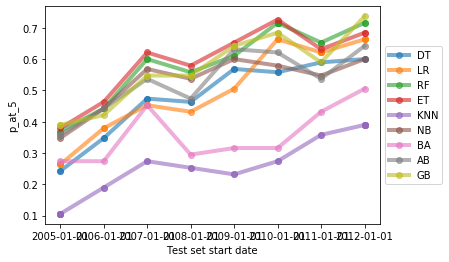

<Figure size 432x288 with 0 Axes>

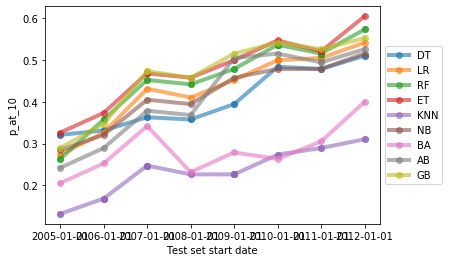

<Figure size 432x288 with 0 Axes>

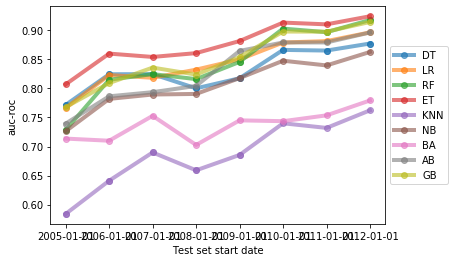

In [66]:
importlib.reload(pipeline)

for metric in metrics_to_display:
    #For each model, find the set of parameters that work the best in each train/test set
    best_models = pipeline.get_best_models_of_each_type_for_each_train_test_set(models_to_run,results,'test_set_start_date', metric)
    pipeline.plot_models_in_time(models_to_run, best_models, metric)
   